# Rule Translation Reviewer

Use this notebook to step through each guideline clause, inspect its ASP translation, provide a rating (0–3), optionally add comments, and export the evaluation summary to CSV.



In [1]:
from pathlib import Path
import html

import pandas as pd
import yaml
import ipywidgets as widgets
from IPython.display import display

import sys
sys.path.append('..')
from src.review.review_data import build_rule_review_dataset
from src.processing.ASPRuleParser import ASPRuleParser
widgets.HTML("<b>widgets ok</b>")

HTML(value='<b>widgets ok</b>')

In [15]:
PROJECT_ROOT = Path.cwd().parent
CONFIG_PATH = PROJECT_ROOT / "src/configs/config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

# CHANGE THIS to switch between different response files
# Options: "rulegen_response_fired.lp", "in_context_response.txt", "zero_shot_response.txt"
response_file = "rulegen_response_fired.lp"

# Extract a clean name for the review (e.g., "rulegen" from "rulegen_response_fired.lp")
if "rulegen" in response_file:
    review_name = "rulegen_test"
elif "in_context" in response_file:
    review_name = "in_context_test"
elif "zero_shot" in response_file:
    review_name = "zero_shot_test"
else:
    review_name = response_file.replace('.lp', '').replace('.txt', '')

# Create reviews directory if it doesn't exist
reviews_dir = PROJECT_ROOT / config["experiment"]["output_dir"] / "reviews"
reviews_dir.mkdir(exist_ok=True)

guideline_path = PROJECT_ROOT / config["input_files"]["problem_text"]
lp_file_path = PROJECT_ROOT / config["experiment"]["output_dir"] / config["experiment"]["cancer_type"] / response_file
review_csv_path = reviews_dir / f"rule_review_{review_name}.csv"

dataset = build_rule_review_dataset(str(guideline_path), str(lp_file_path))

# Expand dataset: for each guideline with multiple ASP rules, create separate rows
# so we can review each ASP rule individually
expanded_records = []
for item in dataset:
    asp_rules = item.asp_rules
    if not asp_rules:
        # No translation - still show the guideline
        expanded_records.append({
            "guideline_id": item.guideline_id,
            "guideline_text": item.guideline_text,
            "asp_rule_id": None,
            "asp_rule_text": None,
            "asp_rule_index": 0,
            "total_asp_rules": 0,
        })
    else:
        # Show guideline once, then each ASP rule individually
        for idx, rule in enumerate(asp_rules):
            expanded_records.append({
                "guideline_id": item.guideline_id,
                "guideline_text": item.guideline_text,
                "asp_rule_id": rule["rule_id"],
                "asp_rule_text": rule["rule_text"],
                "asp_rule_index": idx,
                "total_asp_rules": len(asp_rules),
            })

df = pd.DataFrame(expanded_records)
df["rating"] = None
df["comment"] = ""

# Try to load existing review if it exists
if review_csv_path.exists():
    try:
        existing_df = pd.read_csv(review_csv_path)
        # Fill NaN values in existing_df for comparison
        existing_df["asp_rule_id"] = existing_df["asp_rule_id"].fillna("")
        
        # Merge existing ratings and comments by matching guideline_id and asp_rule_id
        loaded_count = 0
        # Normalize existing_df for comparison
        existing_df["asp_rule_id"] = existing_df["asp_rule_id"].astype(str).fillna("")
        existing_df["guideline_id"] = existing_df["guideline_id"].astype(str)
        
        for idx, row in df.iterrows():
            current_asp_rule_id = str(row["asp_rule_id"]) if pd.notna(row["asp_rule_id"]) else ""
            current_guideline_id = str(row["guideline_id"])
            
            match = existing_df[
                (existing_df["guideline_id"] == current_guideline_id) &
                (existing_df["asp_rule_id"] == current_asp_rule_id)
            ]
            if not match.empty:
                match_row = match.iloc[0]
                rating_val = match_row.get("rating")
                comment_val = match_row.get("comment", "")
                
                if pd.notna(rating_val):
                    try:
                        df.at[idx, "rating"] = int(float(rating_val))
                    except (ValueError, TypeError):
                        pass
                if pd.notna(comment_val) and str(comment_val).strip() != "nan":
                    df.at[idx, "comment"] = str(comment_val)
                loaded_count += 1
        if loaded_count > 0:
            display(f"Loaded existing review from {review_csv_path} ({loaded_count} items)")
    except Exception as e:
        display(f"Could not load existing review: {e}")

translations_count = df["asp_rule_id"].notna().sum()
display(f"Reviewing: {review_name}")
display(f"Loaded {len(df)} review items ({len(dataset)} guidelines, {translations_count} ASP rule translations).")



'Reviewing: rulegen_test'

'Loaded 40 review items (25 guidelines, 38 ASP rule translations).'

In [16]:
rating_labels = {
    0: "0 – Completely wrong interpretation",
    1: "1 – Completely right",
    2: "2 – Slightly wrong interpretation",
    3: "3 – Key information missed",
    4: "4 – Information hallucinated",
}

rating_options = [("Select rating", None)] + [
    (label, value) for value, label in rating_labels.items()
]

asp_parser = ASPRuleParser() 

current_index = 0
rule_display = widgets.HTML(layout=widgets.Layout(width="100%"))
rating_dropdown = widgets.Dropdown(options=rating_options, value=None, description="Rating:")
comment_box = widgets.Textarea(
    value="",
    description="Comment:",
    placeholder="Optional notes...",
    layout=widgets.Layout(width="100%", height="100px"),
)
progress_label = widgets.Label()
output_area = widgets.Output()

prev_button = widgets.Button(description="◀ Previous", button_style="info")
next_button = widgets.Button(description="Next ▶", button_style="info")
save_button = widgets.Button(description="Save to CSV", button_style="success")
summary_button = widgets.Button(description="Show Summary", button_style="warning")


def _format_html_text(text: str) -> str:
    escaped = html.escape(text)
    return escaped.replace("\n", "<br>")


def build_rule_html(row: pd.Series) -> str:
    guideline_html = f"<h3>Guideline {row['guideline_id']}</h3><p>{_format_html_text(row['guideline_text'])}</p>"
    # Show the specific ASP rule being reviewed
    asp_rule_id = row.get("asp_rule_id")
    asp_rule_text = row.get("asp_rule_text")
    total_asp_rules = row.get("total_asp_rules", 0)
    asp_rule_index = row.get("asp_rule_index", 0)
    
    if pd.notna(asp_rule_id) and asp_rule_text:
        # Show which rule we're reviewing if there are multiple
        rule_counter = ""
        if total_asp_rules > 1:
            rule_counter = f" (Rule {asp_rule_index + 1} of {total_asp_rules})"
        
        rule_id_escaped = html.escape(str(asp_rule_id))
        rule_text_escaped = _format_html_text(str(asp_rule_text))
        
        # Generate natural language explanation
        try:
            nl_explanation = asp_parser.explain_rule(str(asp_rule_text), str(asp_rule_id))
            nl_explanation_escaped = _format_html_text(nl_explanation)
            nl_section = f"<div style='margin-top:12px; padding:12px; background-color:#e8f4f8; border-left: 4px solid #2196F3;'><strong>Natural Language:</strong><br>{nl_explanation_escaped}</div>"
        except Exception as e:
            nl_section = f"<div style='margin-top:12px; padding:8px; background-color:#ffebee; border-left: 4px solid #f44336;'><em>Error parsing rule: {html.escape(str(e))}</em></div>"
        
        asp_html = f"""
        <h4>ASP Translation{rule_counter}</h4>
        <div style='margin:10px 0;'>
            <code>{rule_id_escaped}</code><br>
            <div style='margin-top:8px; font-family:monospace; padding:8px; background-color:#f5f5f5;'>
                {rule_text_escaped}
            </div>
            {nl_section}
        </div>
        """
    else:
        asp_html = "<p><strong>No translation found.</strong></p>"

    return guideline_html + asp_html


def persist_current_state():
    rating_val = rating_dropdown.value
    comment_val = comment_box.value.strip() if comment_box.value else ""
    df.at[current_index, "rating"] = rating_val
    df.at[current_index, "comment"] = comment_val


def update_view():
    row = df.iloc[current_index]
    rule_display.value = build_rule_html(row)
    rating_value = row["rating"]
    if pd.isna(rating_value):
        rating_value = None
    rating_dropdown.value = rating_value
    comment_box.value = str(row["comment"]) if pd.notna(row["comment"]) else ""
    progress_label.value = f"Item {current_index + 1} of {len(df)}"
    prev_button.disabled = current_index == 0
    next_button.disabled = current_index == len(df) - 1


def on_prev(_):
    global current_index
    persist_current_state()
    if current_index > 0:
        current_index -= 1
    update_view()


def on_next(_):
    global current_index
    persist_current_state()
    if current_index < len(df) - 1:
        current_index += 1
    update_view()


def prepare_export_dataframe() -> pd.DataFrame:
    export_df = df.copy()
    # Convert None to empty string for CSV export
    export_df["asp_rule_id"] = export_df["asp_rule_id"].fillna("")
    export_df["asp_rule_text"] = export_df["asp_rule_text"].fillna("")
    export_df["comment"] = export_df["comment"].fillna("")
    return export_df


def on_save(_):
    persist_current_state()
    export_df = prepare_export_dataframe()
    export_df.to_csv(review_csv_path, index=False)
    with output_area:
        output_area.clear_output()
        print(f"Saved {len(export_df)} rows to {review_csv_path}")


def on_summary(_):
    persist_current_state()
    rated = df.dropna(subset=["rating"])
    with output_area:
        output_area.clear_output()
        if rated.empty:
            print("No ratings captured yet.")
            return

        summary = (
            rated.groupby("rating").size().reindex(sorted(rating_labels.keys()), fill_value=0)
        )
        total = summary.sum()
        summary_df = pd.DataFrame({
            "rating": summary.index,
            "description": [rating_labels[idx] for idx in summary.index],
            "count": summary.values,
            "percentage": (summary.values / total * 100).round(2),
        })
        display(summary_df)

        # Filter comments - handle NaN and empty strings
        def has_comment(val):
            if pd.isna(val):
                return False
            s = str(val).strip()
            return s != "" and s.lower() != "nan"
        
        comments_df = rated[rated["comment"].apply(has_comment)]
        if not comments_df.empty:
            display(comments_df[["guideline_id", "asp_rule_id", "comment"]])


prev_button.on_click(on_prev)
next_button.on_click(on_next)
save_button.on_click(on_save)
summary_button.on_click(on_summary)

controls = widgets.VBox([
    rule_display,
    widgets.HBox([rating_dropdown, progress_label]),
    comment_box,
    widgets.HBox([prev_button, next_button, save_button, summary_button]),
    output_area,
])

display(controls)
update_view()



Saved comparison chart: /Users/ashvingupta/Documents/PhD/NICE2ASP2/src/output_files/CLAUDE/reviews/rating_comparison.png


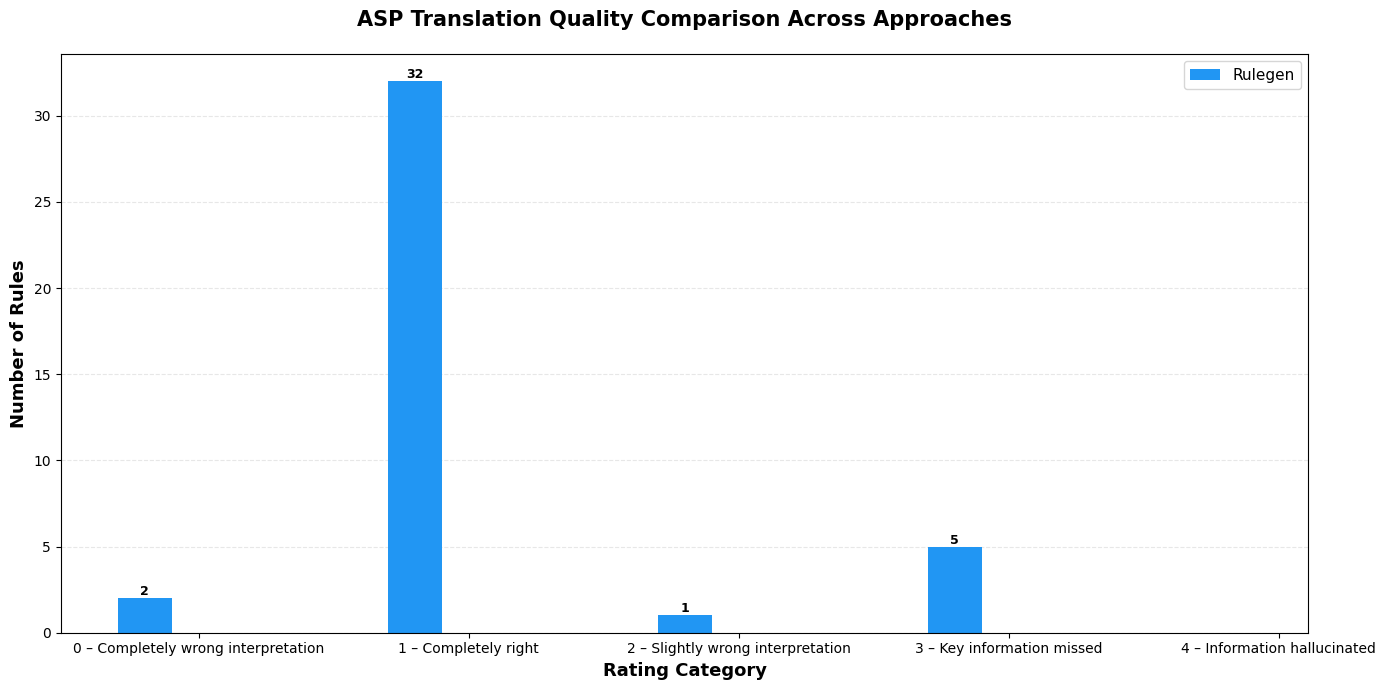


=== Comparison Summary ===
Approach        Total    Right    Accuracy   Wrong    Missed   Halluc  
---------------------------------------------------------------------------
Rulegen         40       32       80.0     % 2        1        5       


In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

# Load the review CSV
PROJECT_ROOT = Path.cwd().parent
CONFIG_PATH = PROJECT_ROOT / "src/configs/config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

reviews_dir = PROJECT_ROOT / config["experiment"]["output_dir"] / "reviews"


# Define rating labels
rating_labels = {
    0: "0 – Completely wrong interpretation",
    1: "1 – Completely right",
    2: "2 – Slightly wrong interpretation",
    3: "3 – Key information missed",
    4: "4 – Information hallucinated",
}

review_files = {
    'Rulegen': 'rule_review_rulegen.csv',
    'In-Context': 'rule_review_in_context.csv',
    'Zero-Shot': 'rule_review_zero_shot.csv',
}

# Collect data for all approaches
all_data = {}
for approach_name, filename in review_files.items():
    review_path = reviews_dir / filename
    if review_path.exists():
        df = pd.read_csv(review_path)
        rated_df = df[df['rating'].notna() & (df['rating'] != '')]
        if len(rated_df) > 0:
            rating_counts = rated_df['rating'].value_counts()
            all_data[approach_name] = {
                'counts': rating_counts,
                'total': len(rated_df)
            }

if not all_data:
    print("No review data found!")
else:
    # Create comparison chart
    fig, ax = plt.subplots(figsize=(14, 7))
    
    x = np.arange(5)  # 4 rating categories (0, 1, 2, 3, 4)
    width = 0.2
    multiplier = 0
    
    colors = {'Rulegen': '#2196F3', 'In-Context': '#4CAF50', 'Zero-Shot': '#FF9800'}
    
    for approach_name, data in all_data.items():
        counts = [data['counts'].get(i, 0) for i in range(5)]
        offset = width * multiplier
        bars = ax.bar(x + offset, counts, width, label=approach_name, 
                      color=colors.get(approach_name, '#999'))
        
        # Add value labels
        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height)}',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        multiplier += 1
    
    ax.set_xlabel('Rating Category', fontsize=13, fontweight='bold')
    ax.set_ylabel('Number of Rules', fontsize=13, fontweight='bold')
    ax.set_title('ASP Translation Quality Comparison Across Approaches', 
                 fontsize=15, fontweight='bold', pad=20)
    ax.set_xticks(x + width)
    ax.set_xticklabels([rating_labels[i] for i in range(5)])
    ax.legend(loc='upper right', fontsize=11)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)
    
    plt.tight_layout()
    
    # Save
    output_path = reviews_dir / "rating_comparison.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    print(f"Saved comparison chart: {output_path}")
    
    plt.show()
    
    # Print comparison table
    print("\n=== Comparison Summary ===")
    print(f"{'Approach':<15} {'Total':<8} {'Right':<8} {'Accuracy':<10} {'Wrong':<8} {'Missed':<8} {'Halluc':<8}")
    print("-" * 75)
    for approach_name, data in all_data.items():
        counts = data['counts']
        total = data['total']
        right = counts.get(1, 0)
        accuracy = (right / total * 100) if total > 0 else 0
        print(f"{approach_name:<15} {total:<8} {right:<8} {accuracy:<9.1f}% "
              f"{counts.get(0, 0):<8} {counts.get(2, 0):<8} {counts.get(3, 0):<8}")